# Matthew's Data Manipulation and Analysis

In this Notebook I will be taking a look at the data from the "IMDB" and "The Numbers" databases. Based on my findings, I will produce a recommendation that is relevant for the client.

**Which genre(s) give the most lift to profit? ROI? Profit margin?**

I will clean, investigate, and visualize data in relation to this question.

In [2]:
# Import relevant Python packages.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Open and save data from "IMDB" and "The Numbers" csv files,
imdb = pd.read_csv("../Data/imdb_data")
tn = pd.read_csv("../Data/tn_data")

In [4]:
# Visually confirm IMDB data loaded as expected
imdb.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes
0,sunghursh2013,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0
1,one day before the rainy season2019,One Day Before the Rainy Season,114.0,"Biography,Drama",7.2,43.0
2,the other side of the wind2018,The Other Side of the Wind,122.0,Drama,6.9,4517.0
3,sabse bada sukh2018,Sabse Bada Sukh,NaN,"Comedy,Drama",6.1,13.0
4,the wandering soap opera2017,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy",6.5,119.0


In [5]:
# Visually confirm TN data loaded as expected
tn.head()

,movie_id,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin
0,avatar2009,1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,5.532577,335507625,0.441163,0.846921
1,pirates of the caribbean: on stranger tides2011,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673,-169536125,-0.703283,0.607331
2,dark phoenix2019,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108,-307237650,-7.184770,-1.337036
3,avengers: age of ultron2015,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841,128405868,0.279748,0.764364
4,star wars ep. viii: the last jedi2017,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696,303181382,0.488859,0.759251


## Data Preperation

### IMDB
The data requires a bit more cleaning before we begin.

In [6]:
# Our group decided to drop the IMDB rows where the 'numvotes' column = 0/NaN as these entries are usually an error
imdb.dropna(subset=['numvotes'], inplace=True)


In [7]:
# Confirm rows were dropped by checking how many rows there are.
imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 146134
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   runtime_minutes  66236 non-null  float64
 3   genres           73052 non-null  object 
 4   averagerating    73856 non-null  float64
 5   numvotes         73856 non-null  float64
dtypes: float64(3), object(3)
memory usage: 3.9+ MB


In [8]:
# Remove the duplicate values in 'movie_id' and keep the entry with the most votes
imdb = imdb.sort_values('numvotes', ascending=False).drop_duplicates(subset='movie_id')
#I sorted the table by 'numvotes', descending, and then kept the first occurance of an entry.

# Confirming duplicated were deleted.
imdb.duplicated('movie_id').value_counts()

False    73264
dtype: int64

In [9]:
# For the objective, I need to turn the 'genres' column into something more uniform
# Split the genre column
imdb['genres'] = imdb['genres'].str.split(',')

# explode the genres column into rows for each genre
imdb = imdb.explode('genres')
#visually confirm expected results
imdb.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes
7066,inception2010,Inception,148.0,Action,8.8,1841066.0
7066,inception2010,Inception,148.0,Adventure,8.8,1841066.0
7066,inception2010,Inception,148.0,Sci-Fi,8.8,1841066.0
6900,the dark knight rises2012,The Dark Knight Rises,164.0,Action,8.4,1387769.0
6900,the dark knight rises2012,The Dark Knight Rises,164.0,Thriller,8.4,1387769.0


### The Numbers

In [10]:
# Check for duplicates
tn[tn.duplicated(subset=['movie_id'], keep=False)]

,movie_id,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin
3455,home2009,56,2009-06-05,Home,12000000,0,0,-12000000,-1.000000,-12000000,-inf,-inf
5459,home2009,60,2009-04-23,Home,500000,15433,44793168,44293168,88.586336,-484567,-31.398108,0.988838


It is two different movies with the same name, it would be normally fine to keep both of them, but because one has a "worldwide_gross" of 0 we will be removing it anyway.

In [11]:
# My group agreed to remove any row with a 'worldwide_gross' of 0 since it is probably a placeholder value.
tn['worldwide_gross'].value_counts().head(1)

0    367
Name: worldwide_gross, dtype: int64

In [12]:
# Remove "worldwide_gross" rows that are 0
tn.drop(tn[tn['worldwide_gross'] == 0].index, inplace=True)

In [13]:
# Visually confirm expected results
tn[tn['worldwide_gross'] == 0]

,movie_id,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin


### Join Tables

In [14]:
# Merge tables on "move_id" column
imdb_tn = imdb.merge(tn, on='movie_id')

# Visually confirm expected results
imdb_tn.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin
0,inception2010,Inception,148.0,Action,8.8,1841066.0,38,2010-07-16,Inception,160000000,292576195,835524642,675524642,4.222029,132576195,0.453134,0.808504
1,inception2010,Inception,148.0,Adventure,8.8,1841066.0,38,2010-07-16,Inception,160000000,292576195,835524642,675524642,4.222029,132576195,0.453134,0.808504
2,inception2010,Inception,148.0,Sci-Fi,8.8,1841066.0,38,2010-07-16,Inception,160000000,292576195,835524642,675524642,4.222029,132576195,0.453134,0.808504
3,the dark knight rises2012,The Dark Knight Rises,164.0,Action,8.4,1387769.0,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,809439099,2.943415,173139099,0.386351,0.746413
4,the dark knight rises2012,The Dark Knight Rises,164.0,Thriller,8.4,1387769.0,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,809439099,2.943415,173139099,0.386351,0.746413


In [65]:
# Group the table by generes, and aggregate by the median. Sort by "worldwide_gross", descending
grouped_imdb_tn = imdb_tn.groupby('genres').median().sort_values('ROI', ascending=False)

# Visually confirm expected results
grouped_imdb_tn

,runtime_minutes,averagerating,numvotes,id,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin
genres,,,,,,,,,,,,
Mystery,105.0,6.30,68998.0,55.0,14500000.0,26851266.5,61166295.5,39117893.5,2.573175,5842441.0,0.373493,0.719501
Horror,95.5,5.90,47808.5,55.0,10000000.0,26197915.5,44202303.5,29065832.0,2.296345,5946759.5,0.211461,0.696634
Animation,95.0,6.70,73170.5,43.5,87500000.0,113370261.5,316450194.5,202467009.0,1.996890,19525370.0,0.129395,0.666321
Sci-Fi,112.0,6.60,204481.0,50.0,90000000.0,78765986.0,240647629.0,123617305.0,1.778310,2853933.0,0.092566,0.640069
Adventure,108.0,6.50,123127.0,46.0,100000000.0,83670083.0,249517956.0,133691277.0,1.659514,-2464983.0,-0.059707,0.623991
Thriller,105.0,6.30,78932.5,54.5,21000000.0,30570973.5,57176634.0,35944700.5,1.534840,1052201.0,0.035539,0.605495
Comedy,102.0,6.30,59253.0,50.0,29000000.0,40847995.0,70027933.0,35768579.0,1.494504,4669521.0,0.193255,0.599119
Romance,105.0,6.30,55698.0,58.0,18000000.0,24477704.0,42843521.0,19795070.0,1.369697,2915773.0,0.196744,0.578005
Music,107.0,6.40,22977.0,58.0,15000000.0,20218921.0,32700439.0,12876066.0,1.287002,3432113.0,0.258121,0.562746


My group decided we would use median as a measure of central tendency, as there are extreme outliers that were affecting the means of this value.  


## Visualizations

From here I will be making 3 graphs:

- A graph of the median ROI value by movie genre
- A graph showing the 90th percentile values by movie genre
- A graph showing the 10th percentile value by movie genre.

These visuals will assist in informing and communicating our final recommendation.

## Median ROI by Movie Genre

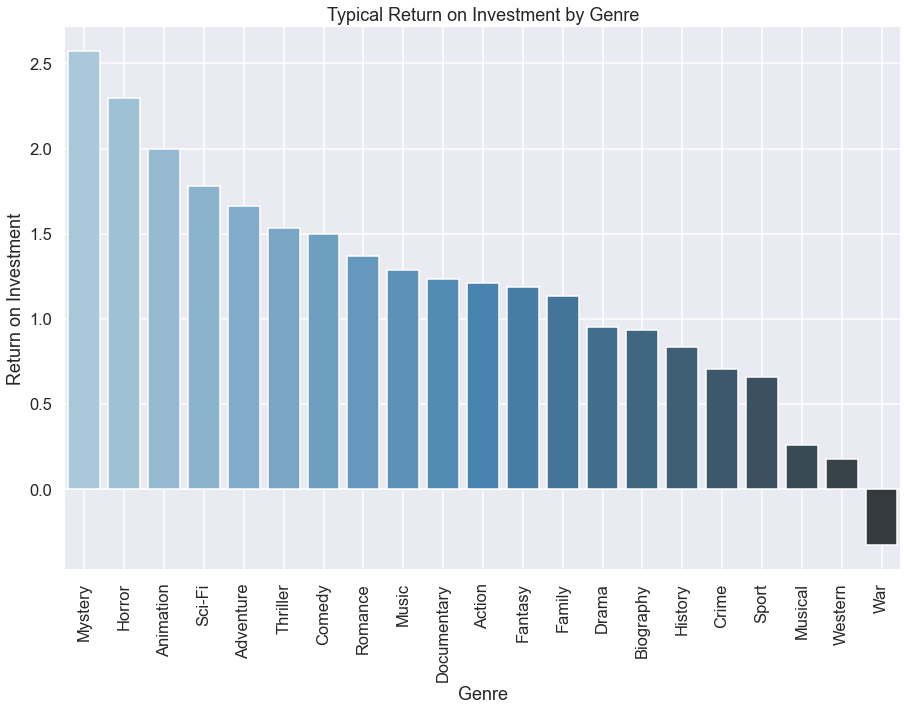

In [33]:
# Define figure/axis
fig, ax = plt.subplots()

# Set Seaborn figure size and style
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(context='talk')

# Create visual
imdb_tn_meidan = sns.barplot(data=grouped_imdb_tn, x=grouped_imdb_tn.index, y='ROI', ax=ax, palette="Blues_d" )

# Customize asthetic
imdb_tn_meidan.set_xticklabels(imdb_tn_meidan.get_xticklabels(),rotation = 90) # rotate xaxis tick labels
ax.xaxis.grid(True) # Show the vertical gridlines
imdb_tn_meidan.set_title('Typical Return on Investment by Genre')
imdb_tn_meidan.set_xlabel('Genre')
imdb_tn_meidan.set_ylabel('Return on Investment');
plt.tight

Just from this graph it is clear that some genres of movies have a higher return on investment then others. But this doesn't tell the whole story either, let's look at the top 10% and bottom 10% of ROIS and see what their genre is. This will help inform what the best and worst case scenerios may be according to this set.

## 90th percentile ROI by genre

In [35]:
# Group by top 10% and sort by ROI
top_imdb_tn = imdb_tn.groupby('genres').quantile(q=0.9).sort_values('ROI', ascending=False)

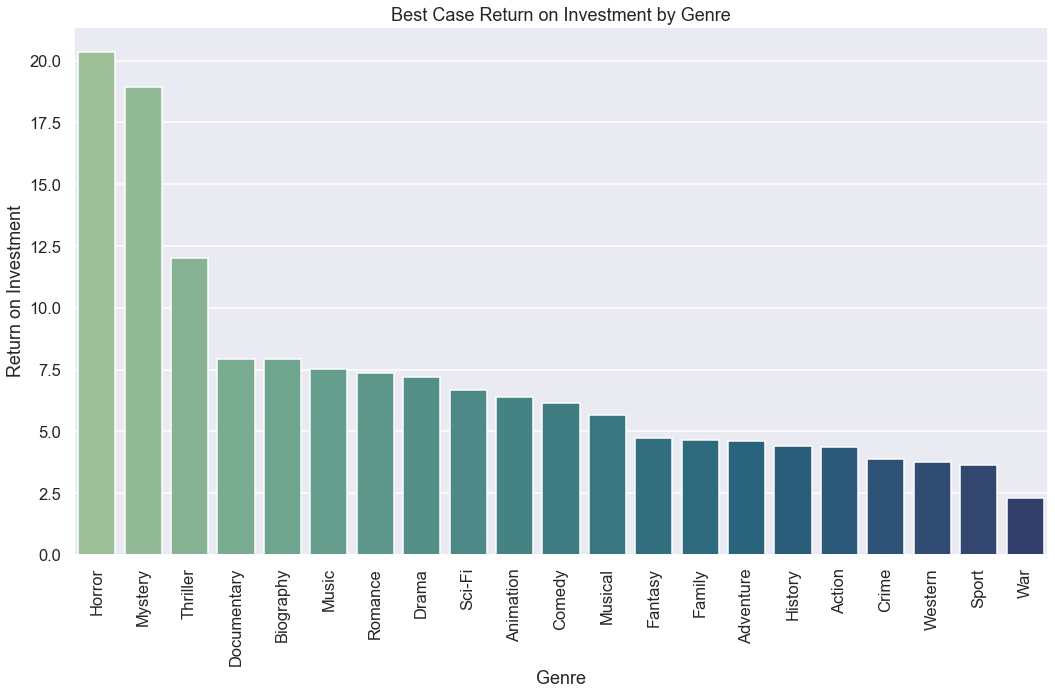

In [36]:
# Create visual
figtop, axtop = plt.subplots()

top = sns.barplot(data=top_imdb_tn, x=top_imdb_tn.index, y='ROI', ax=axtop, palette="crest" )

# Customize asthetic
top.set_xticklabels(top.get_xticklabels(),rotation = 90) # rotate xaxis tick labels
ax.xaxis.grid(True) # Show the vertical gridlines
top.set_title("Best Case Return on Investment by Genre")
top.set_xlabel('Genre')
top.set_ylabel('Return on Investment');


## Worst Performing Movies


In [39]:
# Group by bottom 10% and sort by ROI
bottom_imdb_tn = imdb_tn.groupby('genres').quantile(q=0.1).sort_values('ROI', ascending=False)

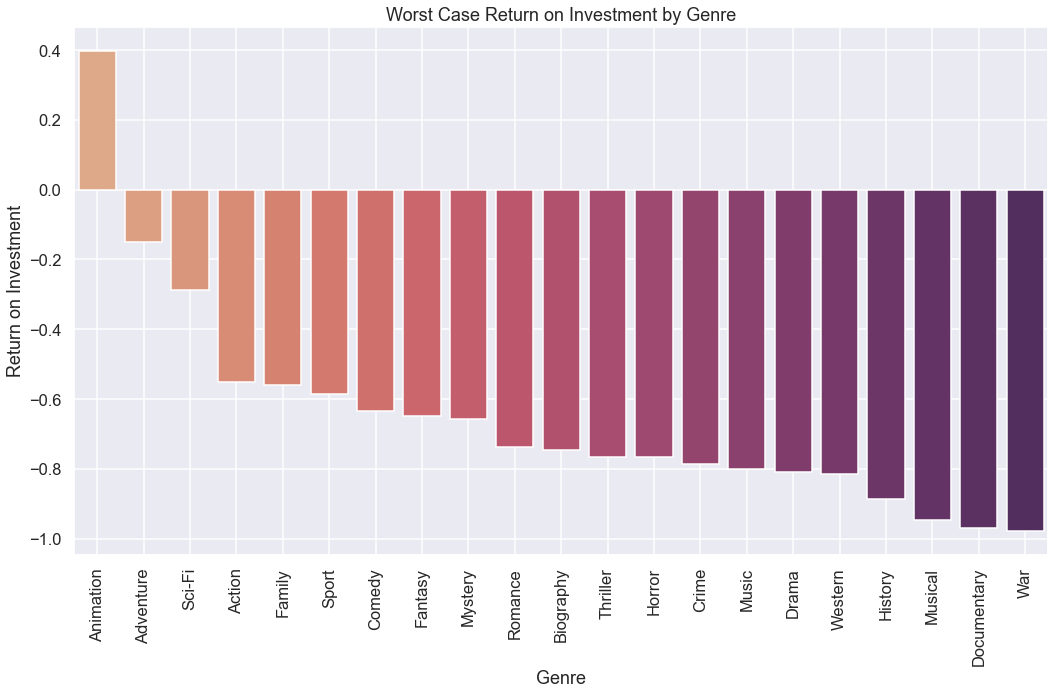

In [40]:
# Create visual
figbot, axbot = plt.subplots()

bot = sns.barplot(data=bottom_imdb_tn, x=bottom_imdb_tn.index, y='ROI', ax=axbot, palette="flare" )

# Customize asthetic
bot.set_xticklabels(bot.get_xticklabels(),rotation = 90) # rotate xaxis tick labels
axbot.xaxis.grid(True) # Show the vertical gridlines
bot.set_title("Worst Case Return on Investment by Genre")
bot.set_xlabel('Genre')
bot.set_ylabel('Return on Investment');

## Analysis

According to our scenario, Microsoft is opening a new movie studio, and we are going to be meeting with the new director of the studio to make recommendations on how to procced.  

The important thing to note is that this is a brand new studio. The team will be newly formed, and will need to get used to working together. They will also need to prove their worth as a team to microsoft as a whole, so it is vitally important that their first project is success.

If we just looked at the "Typical Return on Investment by Genre" graph it might be easy to assume that we should reccomend a horror or thriller movie since they typically have a higher ROI then other genres. The next graph, "Best Case Return on Investment by Genre," also shows that when those kinds of movies do well, they have an extremely high return on investment. However, this is a new movie studio. The chances of them making a knockout film are unrealistic, and because they are a new studio looking to prove themselves, they can't afford to make a mistake. If we take a look at the **worst** case scenario, we can see that when Horror/Thriller movies have a low return on investment they typically have a lower ROI then other genres. In layman's terms, when a horror/thriller performs poorly, it performs **very** poorly.

In this scenario, we would reccomend that Microsoft's new studio make an animated film.

- Animation films typically have a better ROI then other genres
- In the best cases, animation films don't do as well as other genres however,
- Most importantly, in the worst case scenario animation films are the only genre that has a positive ROI.

This is a new studio, they won't be expecting to make a perfect movie on their first project. They will be looking to play it safe, to justify their creation, and to justify future funding. Therefore because animated films do reasonably well across all scenarios the safest choice would to be an animated film.

## Recommendation

**Microsoft's new studio should make an animated film.**

This is a new studio, they won't be expecting to make a perfect movie on their first project. They will be looking to play it safe, to justify their creation, and to justify future funding. Therefore because animated films do reasonably well across all scenarios the safest choice would to be an animated film.

**Making an animated film will typically give a 50% increase to your return on investment**


# Venus Analytics Action Plan For 'Microsoft Studios' Start Up.


## Our action plan was formed around 3 Business Questions.

- What time of year should Microsoft release the majority of their movies? 

- What genre of movies should be their Primary Focus?

- needs to be stated

### Data Exploration Stage

First we need to import the libraries and datesets

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [40]:
!ls Data/zippedData/

bom.movie_gross.csv.gz
imdb.name.basics.csv.gz
imdb.title.akas.csv.gz
imdb.title.basics.csv.gz
imdb.title.crew.csv.gz
imdb.title.principals.csv.gz
imdb.title.ratings.csv.gz
rt.movie_info.tsv.gz
rt.reviews.tsv.gz
tmdb.movies.csv.gz
tn.movie_budgets.csv.gz


In [41]:
# we uses pandas to view our csv datasets as dataframes

bom = pd.read_csv('Data/zippedData/bom.movie_gross.csv.gz')
num = pd.read_csv('Data/zippedData/tn.movie_budgets.csv.gz')
#rt =  pd.read_tsv('Data/zippedData/rt.reviews.tsv.gz')
imdb_title = pd.read_csv('Data/zippedData/imdb.title.basics.csv.gz')
tmdb = pd.read_csv('Data/zippedData/tmdb.movies.csv.gz')
#pd.read_csv('Data/zippedData/')


## Box Office Mojo

In [42]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


###### This table is missing almost 1/3rd of its foreign gross and we are giving microsoft recommendations for global success.

In [43]:
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [44]:
bom.tail(15)

,title,studio,domestic_gross,foreign_gross,year
3372,Gabriel and the Mountain,Strand,18400.0,NaN,2018
3373,Marlina the Murderer in Four Acts,Icar.,17800.0,NaN,2018
3374,The Escape,IFC,14000.0,NaN,2018
3375,How Victor 'The Garlic' Took Alexey 'The Stud'...,CARUSEL,13000.0,NaN,2018
3376,"Lou Andreas-Salomé, the Audacity to be Free",CLS,12900.0,NaN,2018
3377,Let Yourself Go,Men.,12200.0,NaN,2018
3378,Hannah (2018),PDF,11700.0,NaN,2018
3379,Souvenir,Strand,11400.0,NaN,2018
3380,Furious (Legend of Kolovrat),CARUSEL,10000.0,NaN,2018
3381,Beauty and the Dogs,Osci.,8900.0,NaN,2018


###### To make things even worse, this dataset is missing foreign_gross on the more recent movies.  We are trying to tell Microsoft what is trending today.

After looking at our next dataset we decided to just use The Numbers for our financial data.  The only thing that Box Office Mojo has that The Numbers doesn't is the studio name, and that information does not help answer our business question.

### "The Numbers"

Quick glance at our dataset

In [45]:
num.head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
7,8,"May 24, 2007",Pirates of the Caribbean: At Worldâs End,"$300,000,000","$309,420,425","$963,420,425"
8,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,"Nov 6, 2015",Spectre,"$300,000,000","$200,074,175","$879,620,923"


In [46]:
num.tail(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
5772,73,"Jan 13, 2012",Newlyweds,"$9,000","$4,584","$4,584"
5773,74,"Feb 26, 1993",El Mariachi,"$7,000","$2,040,920","$2,041,928"
5774,75,"Oct 8, 2004",Primer,"$7,000","$424,760","$841,926"
5775,76,"May 26, 2006",Cavite,"$7,000","$70,071","$71,644"
5776,77,"Dec 31, 2004",The Mongol King,"$7,000",$900,$900
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
5781,82,"Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


##### Right away we notice that our financial data are not integers due to the prescense of  $ signs and commas

In [47]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


##### In order for us to change our financial columns into integers, we must first strip them of their non numeric elements.

In [48]:
# This code removes the '$' from our financial data.

num['worldwide_gross'] = num['worldwide_gross'].str.strip('$')
num['domestic_gross'] = num['domestic_gross'].str.strip('$')
num['production_budget'] = num['production_budget'].str.strip('$')

In [49]:
# Now we remove the commas

num['worldwide_gross'] = num['worldwide_gross'].str.replace(',', '' )
num['domestic_gross'] = num['domestic_gross'].str.replace(',', '')
num['production_budget'] = num['production_budget'].str.replace(',', '')

###### Double check to see if all of our commas and '$' signs are gone.

In [50]:
num.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


###### Now our 3 columns can be changed into numeric data

In [51]:
# overwriting our collumns and changing the data type to int.

num['production_budget'] = pd.to_numeric(num['production_budget'])
num['domestic_gross'] = pd.to_numeric(num['domestic_gross'])
num['worldwide_gross'] = pd.to_numeric(num['worldwide_gross'])

In [52]:
num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 271.2+ KB


### While we have some great financial data here, we still lack financial measurements that show us profit.

###### We can add columns to give us more insight
- Domestic Profit = domestic_gross minus production_budget
- Worldwide Profit = worldwide_gross minus production_budget
- Worldwide ROI = worldwide_profit divided by production_cost
- Domestic Profit Margin = domestic_profit divided by domestic_gross
- Worldwide Profit Margin = worldwide_profit divided by worldwide_gross

In [53]:
num['worldwide_profit'] = num['worldwide_gross'] - num['production_budget']

num['worldwide_ROI']  =  num['worldwide_profit'] / num['production_budget']

num['domestic_profit'] = num['domestic_gross'] - num['production_budget']

num['domestic_profit_margin'] = num['domestic_profit'] / num['domestic_gross']

num['worldwide_profit_margin'] = num['worldwide_profit'] / num['worldwide_gross'] 

###### Check our work

In [54]:
num.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,worldwide_ROI,domestic_profit,domestic_profit_margin,worldwide_profit_margin
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577,335507625,0.441163,0.846921
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673,-169536125,-0.703283,0.607331
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108,-307237650,-7.184770,-1.337036
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841,128405868,0.279748,0.764364
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696,303181382,0.488859,0.759251


###### My team and I also agreed on making a month column in order to find out the optimal time of year to release movies.

In [55]:
# str.slice the first 3 elements of the release_date and add that to its own seperate column

num['month'] = num['release_date'].str.slice(stop=3)

In [56]:
num.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,worldwide_ROI,domestic_profit,domestic_profit_margin,worldwide_profit_margin,month
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577,335507625,0.441163,0.846921,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673,-169536125,-0.703283,0.607331,May
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108,-307237650,-7.184770,-1.337036,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841,128405868,0.279748,0.764364,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696,303181382,0.488859,0.759251,Dec


###### We plan on merging our tables, and we have decided that we will create a 'movie_id, set it as the index and merge on that.

In [57]:
#Here our movie_id column consists of both the the name of the movie lowercased followed by the year from release_date.

num['movie_id'] = num['movie'].str.lower() + num['release_date'].str.slice(start=-4)

In [58]:
#We take out trailing and leading white space so that we can have as clean of a merge as possible

num['movie_id'].str.slice()

0                                            avatar2009
1       pirates of the caribbean: on stranger tides2011
2                                      dark phoenix2019
3                           avengers: age of ultron2015
4                 star wars ep. viii: the last jedi2017
                             ...                       
5777                                         red 112018
5778                                      following1999
5779                  return to the land of wonders2005
5780                           a plague so pleasant2015
5781                              my date with drew2005
Name: movie_id, Length: 5782, dtype: object

##### The final step to prepare this table for a merge is to set the month_id column as the index. 

In [59]:
num = num.set_index('movie_id')

In [60]:
num.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,worldwide_ROI,domestic_profit,domestic_profit_margin,worldwide_profit_margin,month
movie_id,,,,,,,,,,,,
avatar2009,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2351345279,5.532577,335507625,0.441163,0.846921,Dec
pirates of the caribbean: on stranger tides2011,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673,-169536125,-0.703283,0.607331,May
dark phoenix2019,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108,-307237650,-7.184770,-1.337036,Jun
avengers: age of ultron2015,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841,128405868,0.279748,0.764364,May
star wars ep. viii: the last jedi2017,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696,303181382,0.488859,0.759251,Dec


In [61]:
num['domestic_gross'].value_counts()

0           548
8000000       9
2000000       7
7000000       7
10000000      6
           ... 
449865        1
10547117      1
4476235       1
56653         1
40157856      1
Name: domestic_gross, Length: 5164, dtype: int64

In [62]:
num['worldwide_gross'].value_counts()

0            367
8000000        9
7000000        6
2000000        6
4000000        4
            ... 
166000000      1
42843521       1
101173038      1
478595         1
12996          1
Name: worldwide_gross, Length: 5356, dtype: int64

In [63]:
num.tail()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,worldwide_profit,worldwide_ROI,domestic_profit,domestic_profit_margin,worldwide_profit_margin,month
movie_id,,,,,,,,,,,,
red 112018,78,"Dec 31, 2018",Red 11,7000,0,0,-7000,-1.000000,-7000,-inf,-inf,Dec
following1999,79,"Apr 2, 1999",Following,6000,48482,240495,234495,39.082500,42482,0.876243,0.975051,Apr
return to the land of wonders2005,80,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338,-3662,-0.732400,-3662,-2.736921,-2.736921,Jul
a plague so pleasant2015,81,"Sep 29, 2015",A Plague So Pleasant,1400,0,0,-1400,-1.000000,-1400,-inf,-inf,Sep
my date with drew2005,82,"Aug 5, 2005",My Date With Drew,1100,181041,181041,179941,163.582727,179941,0.993924,0.993924,Aug


##### As we can see in the tail of our dataframe, A 0 in the worldwide_gross column causes a '- infinity' in our worldwide_profit_margin table that can skew our data immensely. 

###### After alot of thought my team and I decided that we had no way of deciphering if  these zeroes were real values or place holders.

There are 2 reasons we decided to drop the zeroes in our worldwide_gross column.

- Microsoft is such a huge company with global influence, so we want accurate financial data on Worldwide_ profit
- Secondly a zero in the worldwide_gross column gives us a negative ininity the worldwide_profit margin column


In [64]:
# Here we drop every row where there is a zero in the worldwide_gross column

num.drop(num[num['worldwide_gross'] == 0].index, inplace=True)

In [65]:
num['worldwide_gross'].value_counts()

8000000      9
2000000      6
7000000      6
4000000      4
5000000      4
            ..
42843521     1
101173038    1
478595       1
58545540     1
104267443    1
Name: worldwide_gross, Length: 5354, dtype: int64

In [66]:
num.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5414 entries, avatar2009 to my date with drew2005
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       5414 non-null   int64  
 1   release_date             5414 non-null   object 
 2   movie                    5414 non-null   object 
 3   production_budget        5414 non-null   int64  
 4   domestic_gross           5414 non-null   int64  
 5   worldwide_gross          5414 non-null   int64  
 6   worldwide_profit         5414 non-null   int64  
 7   worldwide_ROI            5414 non-null   float64
 8   domestic_profit          5414 non-null   int64  
 9   domestic_profit_margin   5414 non-null   float64
 10  worldwide_profit_margin  5414 non-null   float64
 11  month                    5414 non-null   object 
dtypes: float64(3), int64(6), object(3)
memory usage: 549.9+ KB


###### We still have 5415 entries that we can analyze for trends

#### Visualizations Pre Merge

We know that we will lose some data from a merge, so by doing some visualizations before the merge, we will have a bigger sample size to draw financial data from.

<AxesSubplot:title={'center':'Typical Worldwide Gross'}, xlabel='Months', ylabel='Gross Median'>

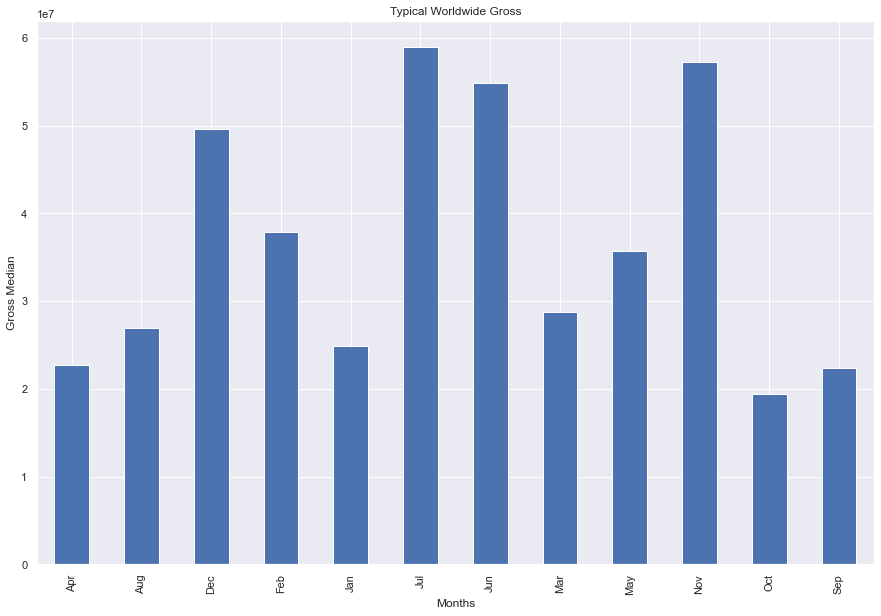

In [67]:
gross_median = num.groupby(['month'])['worldwide_gross'].median()
    
gross_median.plot(kind='bar', title='Typical Worldwide Gross', ylabel='Gross Median',
         xlabel='Months')

<AxesSubplot:title={'center':'Typical Worldwide profit'}, xlabel='Months', ylabel='profit Median'>

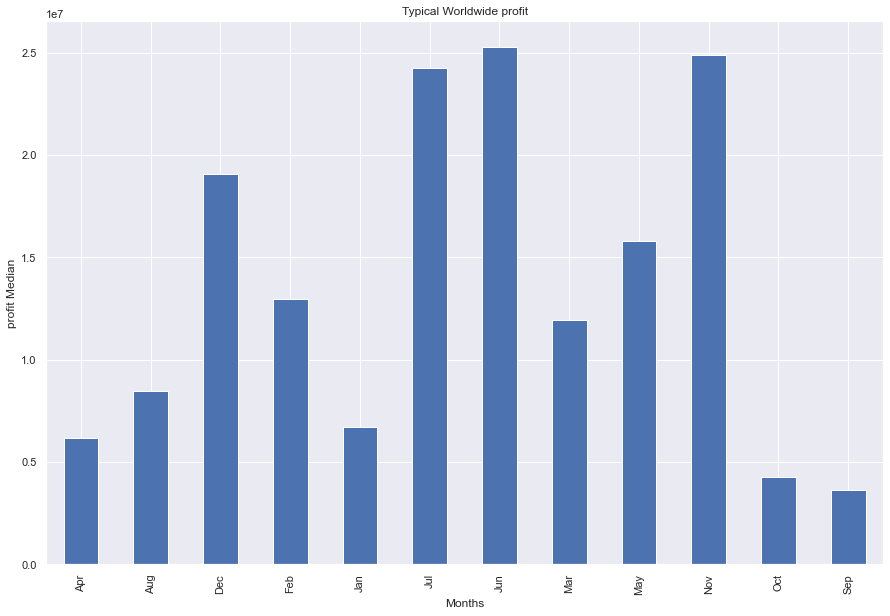

In [68]:
profit_median = num.groupby(['month'])['worldwide_profit'].median()

profit_median.plot(kind='bar', title='Typical Worldwide profit', ylabel='profit Median',
         xlabel='Months')




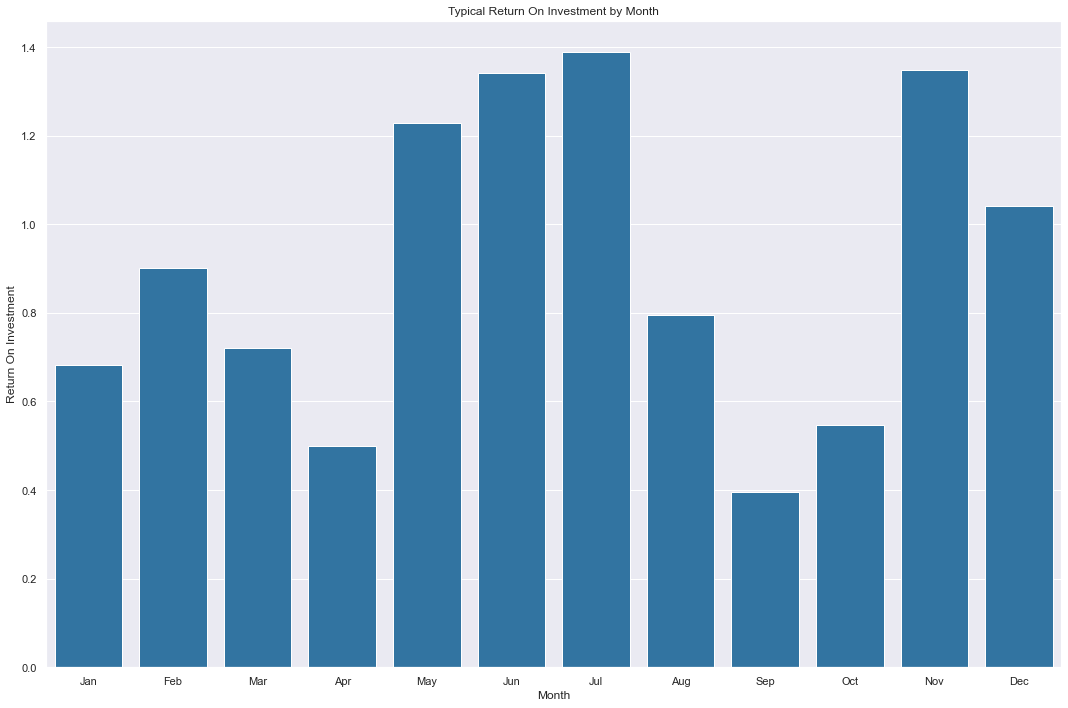

In [87]:
roi_median = num.groupby(['month']).median()


    
month_fig, month_ax = plt.subplots()
sns.set_theme(context='talk')
sns.set(rc={'figure.figsize':(15,10)})

roi_bar = sns.barplot(data= roi_median, x= roi_median.index, y ='worldwide_ROI', color='tab:blue', ax = month_ax, order= [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

roi_bar.set_title('Typical Return On Investment by Month')
roi_bar.set_xlabel('Month')
roi_bar.set_ylabel('Return On Investment');






###### Our first recommendation based on these 3 findings would be to release the bulk of your movies during summer and the Holiday seasons.  These two time periods are consistent over 3 measurements of income.  With a new studio, you would want to justify your profits right away, so it would be wise to follow the release date trend.